# Fractals, Chaos, Complex Numbers

In [65]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees
import os
from random import random, choice
from time import time
import json
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

TODO:

- videos, then nicer colors
- Mandelbrot video - nonlinear movement
- insted of flipping y-axis, directly perform correct transformation to drawing coords
- video (how: series of images -> join in video by a unix command; is it possible to include the video in ntb? at least in the repo -> link from the notebook): zooming / Julia for changing c
- explore colormaps for nicer colors
- add colors based on the last/highest number in the series or other criteria (possible different criteria for different RGB parts)
- compare with Mandelbrot from VPI

-----

# A) Newton Fractal

In [43]:
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
COLORS = [(200, 0, 0), (0, 200, 0), (0, 0, 200)]

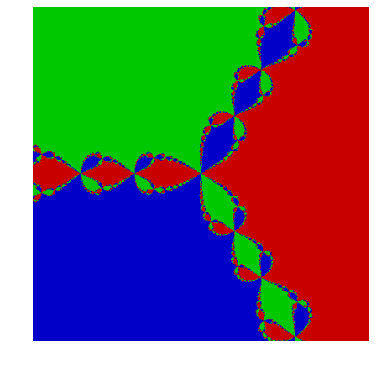

In [3]:
def newton_fractal(xmin=-2, xmax=2, ymin=-2, ymax=2,
                   width=400):
    height = int(width * (ymax-ymin)/(xmax-xmin))
    im = Image.new('RGB', (width, height), color='white') 
    solutions = [1, -0.5 + 1j*sqrt(3)/2, -0.5 - 1j*sqrt(3)/2]
    for ix in range(width):
        for iy in range(height):
            x = xmin + (xmax - xmin) * ix / (width-1)
            y = ymin + (ymax - ymin) * iy / (height-1)
            z = newton_method(x + y*1j)
            i_sol = min(range(3), key=lambda i: abs(z - solutions[i]))
            color = COLORS[i_sol]
            im.putpixel((ix, iy), color)
    return im    

def newton_method(start, n_iter=20):
    point = start
    for i in range(n_iter):
        if point == 0:
            return point
        point = point - (point**3 - 1)/(3 * (point**2))
    return point        

im = newton_fractal()
show_image(im, flipy=True)

-----

# B) Mandelbrot Fractal

TODO:
- factor out image to drawing coordinates transformation
- another colormap (e.g viridis, greens etc.)

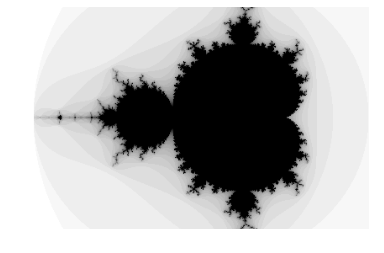

In [4]:
def mandelbrot_fractal(xmin=-2, xmax=1, ymin=-1, ymax=1,
                       n_steps=30, width=400):
    height = int(width * (ymax-ymin)/(xmax-xmin))
    im = Image.new('RGB', (width, height), color='white')
    for ix in range(width):
        for iy in range(height):
            x = xmin + (xmax - xmin) * ix / (width-1)
            y = ymin + (ymax - ymin) * iy / (height-1)
            c = complex(x, y)
            z, steps = mandelbrot_steps(c, n_steps=n_steps)
            intensity = 255 - int(255 * steps/n_steps)
            color = (intensity, intensity, intensity)
            im.putpixel((ix, iy), color)
    return im

def mandelbrot_steps(c, z=complex(0, 0), threshold=2, n_steps=30):
    """Return number of mandelbrot series and number of steps
       needed to exceed the threshold (max n_steps).
    """
    for i_step in range(n_steps):
        z = z**2 + c
        if abs(z) >= threshold:
            return z, i_step
    return z, n_steps

im = mandelbrot_fractal()
show_image(im, flipy=True)

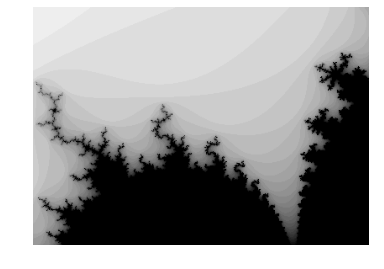

In [5]:
im = mandelbrot_fractal(xmin=-1.3, xmax=-0.6, ymin=0.1, ymax=0.6)
show_image(im, flipy=True)

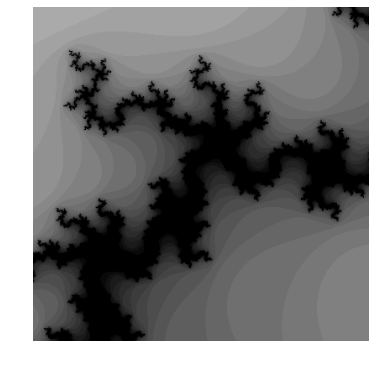

In [84]:
im = mandelbrot_fractal(xmin=-0.94, xmax=-0.92, ymin=0.3, ymax=0.32)
show_image(im, flipy=True)

In [86]:
def save_mandelbrot_images(
        x_end, y_end, eps, n_img,
        xmin_start=-2, xmax_start=1, ymin_start=-1, ymax_start=1):
    os.makedirs('img', exist_ok=True)
    digits = len(str(n_img))
    path_tplt = 'img/mandelbrot-{{i:0{d}d}}.png'.format(d=digits)
    for i in range(1, n_img+1):
        t = 1 - (1-eps) * (i-1)/(n_img-1)
        xmin = xmin_start * t + x_end * (1-t)
        xmax = xmax_start * t + x_end * (1-t)
        ymin = ymin_start * t + y_end * (1-t)
        ymax = ymax_start * t + y_end * (1-t)
        im = mandelbrot_fractal(xmin, xmax, ymin, ymax)
        path = path_tplt.format(i=i)
        im.save(path)
        
def create_mandelbrot_video(x_end, y_end, eps, n_img):
    save_mandelbrot_images(
        x_end=x_end, y_end=y_end, eps=eps, n_img=n_img)
    # Create a video from images:
    d = len(str(n_img))  # digits
    r = 10  # framerate
    ! cd img; \
      ffmpeg -r {r} -i mandelbrot-%0{d}d.png \
        -y -hide_banner -loglevel warning \
        mandelbrot.mp4
        
create_mandelbrot_video(x_end=-0.93, y_end=0.31, eps=0.01, n_img=100)

In [87]:
Video('img/mandelbrot.mp4')

-----

# C) Julia 

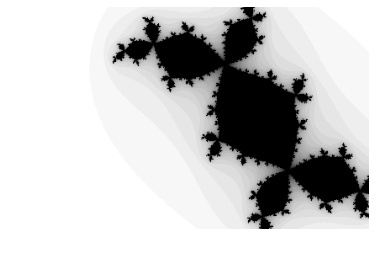

In [56]:
def julia_fractal(c=-0.13+0.75j, xmin=-2, xmax=1, ymin=-1, ymax=1,
                  n_steps=30, width=400):
    height = int(width * (ymax-ymin)/(xmax-xmin))
    im = Image.new('RGB', (width, height), color='white')
    for ix in range(width):
        for iy in range(height):
            x = xmin + (xmax - xmin) * ix / (width-1)
            y = ymin + (ymax - ymin) * iy / (height-1)
            z, steps = mandelbrot_steps(
                c=c, z=complex(x, y), n_steps=n_steps)
            #color = BLACK if abs(z) < 2 else WHITE
            intensity = 255 - int(255 * steps/n_steps)
            color = (intensity, intensity, intensity)
            im.putpixel((ix, iy), color)
    return im

im = julia_fractal()
show_image(im, flipy=True)

In [60]:
def save_julia_images(c_start, c_end, n_img):
    os.makedirs('img', exist_ok=True)
    digits = len(str(n_img))
    path_tplt = 'img/julia-{{i:0{digits}d}}.png'.format(digits=digits)
    for i in range(1, n_img+1):
        t = 1 - (i-1)/(n_img-1) if n_img > 1 else 1
        c = c_start * t + c_end * (1-t)
        im = julia_fractal(c)
        path = path_tplt.format(i=i)
        im.save(path)
        
def create_julia_video(c_start, c_end, n_img):
    save_julia_images(c_start, c_end, n_img=n_img)
    # Create a video from images:
    d = len(str(n_img))  # digits
    r = 10  # framerate
    ! cd img; \
      ffmpeg -r {r} -i julia-%0{d}d.png \
        -y -hide_banner -loglevel warning \
        julia.mp4
        
create_julia_video(c_start=-0.3+0.4j, c_end=-0.13+0.75j, n_img=100)

In [64]:
Video('img/julia.mp4')